# Site

For a given position, reference wind speed (WS<sub>ref</sub>) and wind direction (WD<sub>ref</sub>), `Site` provides the local wind condition in terms of wind speed (WS), wind direction (WD), turbulence intensity (TI) and the probability of each combination of wind direction and wind speed. Furthermore, `Site` is responsible for calculating the down-wind, cross-wind and vertical distance between wind turbines (which in non-flat terrain is different from the straight-line distances).

### Predefined example sites
PyWake contains a few predefined sites of different complexities:
- IEA37Site: `UniformSite` (fix wind speed (9.8m/s), predefined wind sector probability)
- Hornsrev1: `UniformWeibullSite` (weibull distributed wind speed, predefined wind sector propability, uniform wind a over flat wind area)
- ParqueFicticioSite: `WaspGridSite` (Position-dependent weibull distributed wind speed and sector probability. Terrain following distances over non-flat terrain). Loaded from a set of *.grd files exported from WAsP

In [0]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

In [1]:
from py_wake.examples.data.hornsrev1 import Hornsrev1Site
from py_wake.examples.data.iea37 import IEA37Site
from py_wake.examples.data.ParqueFicticio import ParqueFicticioSite

sites = {"IEA37": IEA37Site(n_wt=16), 
         "Hornsrev1": Hornsrev1Site(), 
         "ParqueFicticio": ParqueFicticioSite()}

### Local wind
The method `local_wind` returns a `LocalWind` object:

In [2]:
localWinds = {name: site.local_wind(x_i=site.initial_position[:,0], # x position
                                    y_i = site.initial_position[:,1], # y position
                                    h_i=site.initial_position[:,0]*0+70, # height
                              ws=None, # defaults to 3,4,..,25
                              wd=None, # defaults to 0,1,...,360
                              ) for name, site in sites.items()}
localWinds

{'IEA37': <py_wake.site._site.LocalWind at 0x266ab2334a8>,
 'Hornsrev1': <py_wake.site._site.LocalWind at 0x266ab2334e0>,
 'ParqueFicticio': <py_wake.site._site.LocalWind at 0x266ab233400>}

`LocalWind` objects have four variables:

- WD_ilk: Wind direction
- WS_ilk: Wind speed
- TI_ilk: Turbulence intensity
- P_ilk: Probability of each combination of wind direction and wind speed

with the shape:

In [3]:
for name, lw in localWinds.items():
    print (name, lw.WS_ilk.shape)

IEA37 (16, 360, 1)
Hornsrev1 (80, 360, 23)
ParqueFicticio (8, 360, 23)


The `ilk` suffix indicates that the variables are three-dimensional.

- i: first dimension, number of turbines (16/80/8)
- l: second dimension, number of wind directions (360)
- k: third dimension, number of wind speeds (23)

Wind speeds at first 8 wind turbines for reference wind speed of 3m/s (k=0) and wind from the North (l=0):

In [4]:
for name, lw in localWinds.items():
    print (name, lw.WS_ilk[:8,0,0])

IEA37 [9.8 9.8 9.8 9.8 9.8 9.8 9.8 9.8]
Hornsrev1 [3. 3. 3. 3. 3. 3. 3. 3.]
ParqueFicticio [3.78471012 3.95569235 3.54177811 3.79730687 3.50809716 3.38782152
 2.90165596 2.93723526]


Wind speed at first turbine (i=0) and wind from the North

In [5]:
for name, lw in localWinds.items():
    print (name, lw.WS_ilk[0,0,:])

IEA37 [9.8]
Hornsrev1 [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 24. 25.]
ParqueFicticio [ 3.78471012  5.04628015  6.30785019  7.56942023  8.83099027 10.09256031
 11.35413035 12.61570039 13.87727042 15.13884046 16.4004105  17.66198054
 18.92355058 20.18512062 21.44669066 22.70826069 23.96983073 25.23140077
 26.49297081 27.75454085 29.01611089 30.27768093 31.53925096]


Wind direction at fourth turbine (i=3) for a reference wind speed of 3m/s (k=0) and wind from the East (l=90)

In [6]:
for name, lw in localWinds.items():
    print (name, lw.WD_ilk[3,90,0])

IEA37 90.0
Hornsrev1 90.0
ParqueFicticio 89.73073462034995


### Distance
For the `IEA37Site` and the `Hornsrev1` the distances between points are the straight line distances, as these site types are flat.

For the ParqueFicticioSite, on the other hand, the down-wind distance is larger as it follows the non-flat terrain.

In [7]:
wd = [0, 30,90] # wind direction at source

for name, site in sites.items():
    print ("------- %s -------"%name)
    wt_x, wt_y = site.initial_position[0]
    dw_ijl, cw_ijl,dh_ijl,_ = site.distances(src_x_i=[wt_x], src_y_i=[wt_y], src_h_i=[70],
                                             dst_x_j=[wt_x], dst_y_j=[wt_y-1000], dst_h_j=[90], # wt2 100m to the south
                                             wd_il=[wd])

    print ('Wind direction: \t\t%d deg\t\t%d deg\t\t%d deg'%tuple(wd))
    print ('Down wind distance [m]: \t%.1f\t\t%.1f\t\t%.1f'%tuple(dw_ijl[0,0,:]))
    print ('Cross wind distance [m]: \t%.1f\t\t%.1f\t\t%.1f'%tuple(cw_ijl[0,0,:]))
    print ('Height difference [m]: \t\t%.1f\t\t%.1f\t\t%.1f'%tuple(dh_ijl[0,0,:]))
    print()
    

------- IEA37 -------
Wind direction: 		0 deg		30 deg		90 deg
Down wind distance [m]: 	1000.0		866.0		0.0
Cross wind distance [m]: 	0.0		500.0		1000.0
Height difference [m]: 		20.0		20.0		20.0

------- Hornsrev1 -------
Wind direction: 		0 deg		30 deg		90 deg
Down wind distance [m]: 	1000.0		866.0		0.0
Cross wind distance [m]: 	0.0		500.0		1000.0
Height difference [m]: 		20.0		20.0		20.0

------- ParqueFicticio -------
Wind direction: 		0 deg		30 deg		90 deg
Down wind distance [m]: 	1023.6		886.5		-0.0
Cross wind distance [m]: 	0.0		500.0		1000.0
Height difference [m]: 		20.0		20.0		20.0



### Distribution plots

Site has a few plot function to visualize its properties

In [8]:
import matplotlib.pyplot as plt
site = sites['Hornsrev1']

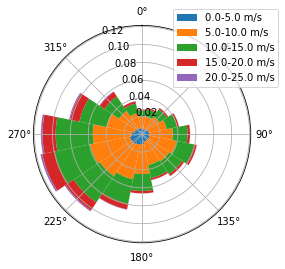

In [9]:
_ = site.plot_wd_distribution(n_wd=16, ws_bins=[0,5,10,15,20,25])

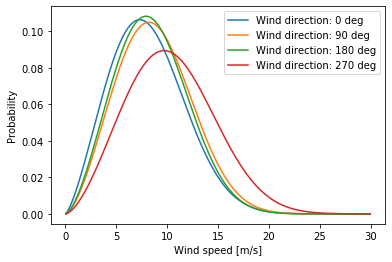

In [10]:
_ = site.plot_ws_distribution(wd=[0,90,180,270])

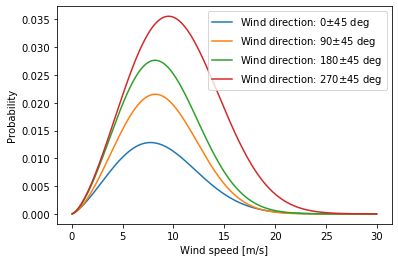

In [11]:
_ = site.plot_ws_distribution(wd=[0,90,180,270], include_wd_distribution=True)